# Geneformer

If you want to learn more about the method please read the [paper](https://www.nature.com/articles/s41586-023-06139-9).

In [1]:
import anndata as ad
import pickle as pkl
from accelerate import Accelerator

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_config  = {
    "model_directory": "./model_files/geneformer-12L-30M", ## Download from Huggingface https://huggingface.co/ctheodoris/Geneformer/tree/main/geneformer-12L-30M
    "batch_size": 5,
    "emb_layer" : -1,#"0"
    "emb_mode":"cell",#"gene" --> cell returns mean embedding
    "device":"cpu"

}

files_config = {
    'token_dictionary_file':"./model_files/token_dictionary.pkl",
    "gene_median_file":"./model_files/gene_median_dictionary.pkl",
}

data_config = {
    "dir": "./",
    "species": "human", #,'macaca_fascicularis',#"human"

}

## Use Geneformer to create embeddings of your data
The Geneformer requires ensembl IDs to process the data but we have a function to map this. Example data can be found [here](https://figshare.com/ndownloader/files/42706966)

In [3]:
ann_data = ad.read_h5ad("../../data/10k_pbmcs_proc.h5ad")
# mappings = load_mappings(ann_data.var["gene_symbols"])
mappings = pkl.load(open('./human_gene_to_ensemble_id.pkl', 'rb'))
ann_data.var['ensembl_id'] = ann_data.var['gene_symbols'].apply(lambda x: mappings.get(x,{"id":None})['id'])
# ann_data.write_h5ad("./data_genetf/10k_pbmcs_proc_genetf.h5ad")

num_indivs = 100

## Use Helical Package

In [4]:
from helical.models.geneformer.geneformer import Geneformer

accelerator = Accelerator(project_dir=data_config["dir"],cpu=True) ## Uses GPU by default on MacOS and Linux
helical_model = Geneformer(model_config,data_config,files_config,accelerator=accelerator)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
dataset = helical_model.process_data(ann_data[:num_indivs],species=data_config["species"])

Fil;e has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 21747.92 examples/s]


Check whether model is on CPU or GPU (MPS for MacOS and CUDA for Nvidia)

In [6]:
helical_model.model.device
# helical_model.model.to("mps")

device(type='cpu')

In [7]:
embeddings = helical_model.get_embeddings(dataset)
embeddings.shape

2024-03-24, 13:40:22.759 Geneformer-Model INFO Inference started
100%|██████████| 20/20 [00:56<00:00,  2.80s/it]


(100, 512)

<Axes: xlabel='px', ylabel='py'>

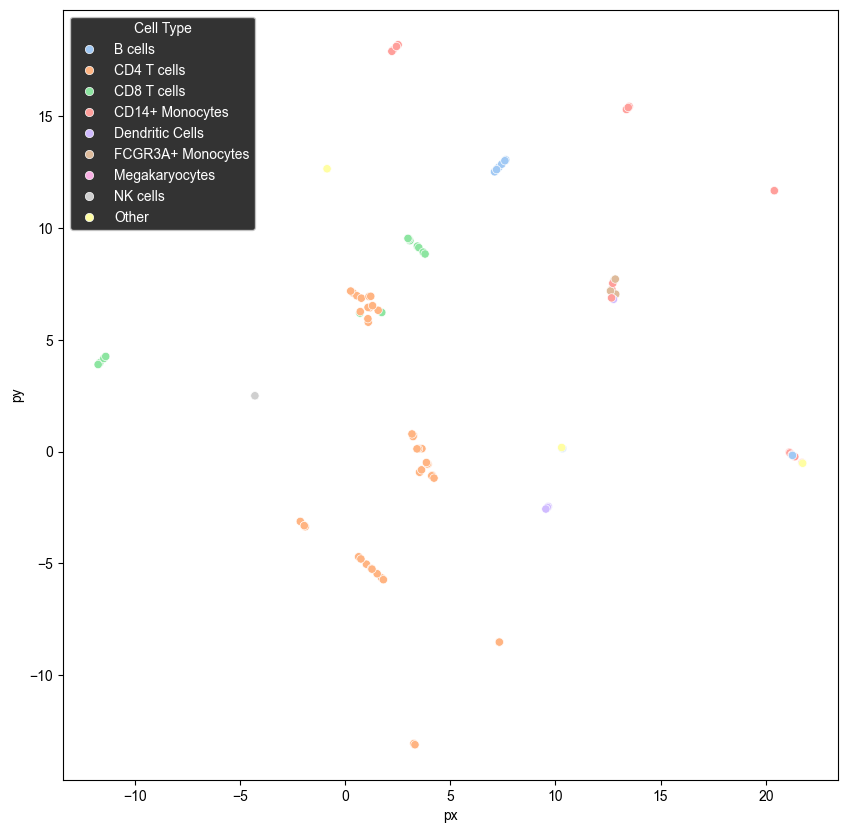

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd

reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=2)
mapper = reducer.fit(embeddings)

labels = ann_data.obs['cell_type'][:num_indivs]
# ax = umap.plot.points(mapper,labels=labels_pf,ax=ax,theme='viridis')

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")
